## 1. read texts from pdf files

In [1]:
model_name = "meta-llama/Llama-3.2-3B-Instruct"
# model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"

In [2]:
import pathlib
import os
import sys
from pymupdf4llm import LlamaMarkdownReader, to_markdown

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# read the markdown file
file_dir = '/home/yuyuan/dataproc/paper_label'
pdf_files = sorted([f for f in os.listdir(file_dir) if f.endswith('.pdf')])
txt_files = sorted([f for f in os.listdir(file_dir) if f.endswith('.txt')])

original_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")
for pdf_file in pdf_files:
    pdf_path = f"{file_dir}/{pdf_file}"
    md_text = to_markdown(pdf_path)
    md_path = f"{file_dir}/{pdf_file[:-4]}.md"
    pathlib.Path(md_path).write_bytes(md_text.encode())
sys.stdout = original_stdout

# read the markdown file
md_texts = []
for pdf_file in pdf_files:
    md_path = f"{file_dir}/{pdf_file[:-4]}.md"
    with open(md_path, "r") as f:
        print(f"Reading {md_path}")
        md_texts.append(f.read())

# read txt files
txt_texts = []
for txt_file in txt_files:
    txt_path = f"{file_dir}/{txt_file}"
    with open(txt_path, "r") as f:
        print(f"Reading {txt_path}")
        txt_texts.append(f.read())

Reading /home/yuyuan/dataproc/paper_label/Knox_2015.md
Reading /home/yuyuan/dataproc/paper_label/Rath_2022.md
Reading /home/yuyuan/dataproc/paper_label/Villa_2024.md
Reading /home/yuyuan/dataproc/paper_label/Wang_2022.md
Reading /home/yuyuan/dataproc/paper_label/Knox_2015_label.txt
Reading /home/yuyuan/dataproc/paper_label/Rath_2022_label.txt
Reading /home/yuyuan/dataproc/paper_label/Villa_2024_label.txt
Reading /home/yuyuan/dataproc/paper_label/Wang_2022_label.txt


In [3]:
# print the md_texts and txt_texts
# for each file, only print the first 20 characters
for i in range(len(md_texts)):
    print(f"md_texts[{i}]: {md_texts[i][:20]}")
for i in range(len(txt_texts)):
    print(f"txt_texts[{i}]: {txt_texts[i][:20]}")

md_texts[0]: # Agricultural peatl
md_texts[1]: https://doi.org/10.5
md_texts[2]: j

**O R I G I N A L
md_texts[3]: Contents lists avail
txt_texts[0]: Paper_Title,Authors,
txt_texts[1]: Paper_Title,Authors,
txt_texts[2]: Paper_Title,Authors,
txt_texts[3]: Paper_Title,Authors,


In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

/home/yuyuan/miniconda3/envs/readpdf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
instruction_prompt_template = '''
    You are a helpful assistant tasked with generating passages that answer users questions from a given context. The questions asked by the used is a header of a csv file. You need to generate rows of records based on the context passage. The context may contain information about multiple records. For one row of record, not all the fields may be present in the context. If you cannot find the answer in the context passage output blank in that cell. 

    Context: {context}'''

question = "Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment"

messages1 = [
  {"role": "system", "content": instruction_prompt_template.format(context=md_texts[0])},
  {"role": "user", "content": question},
  {"role": "assistant", "content": txt_texts[0]}
]

messages2 = [
  {"role": "system", "content": instruction_prompt_template.format(context=md_texts[1])},
  {"role": "user", "content": question},
  {"role": "assistant", "content": txt_texts[1]}
]

messages3 = [
  {"role": "system", "content": instruction_prompt_template.format(context=md_texts[2])},
  {"role": "user", "content": question},
  {"role": "assistant", "content": txt_texts[2]}
]

messages4 = [
  {"role": "system", "content": instruction_prompt_template.format(context=md_texts[3])},
  {"role": "user", "content": question},
  {"role": "assistant", "content": txt_texts[3]}
]


from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

sample_conversation1 = tokenizer.apply_chat_template(messages1, tokenize=False)
sample_conversation2 = tokenizer.apply_chat_template(messages2, tokenize=False)
sample_conversation3 = tokenizer.apply_chat_template(messages3, tokenize=False)
sample_conversation4 = tokenizer.apply_chat_template(messages4, tokenize=False)

conversation1 = {"text": sample_conversation1, "messages": messages1, "answer": txt_texts[0]}
conversation2 = {"text": sample_conversation2, "messages": messages2, "answer": txt_texts[1]}
conversation3 = {"text": sample_conversation3, "messages": messages3, "answer": txt_texts[2]}
conversation4 = {"text": sample_conversation4, "messages": messages4, "answer": txt_texts[3]}

conversation_training_samples = [conversation1, conversation2, conversation3]
conversation_test_samples = [conversation4]

In [6]:
print(conversation_test_samples[0]['answer'])
print(conversation_test_samples)

Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Ka

In [7]:
from datasets import Dataset

# Convert conversation_training_samples and conversation_test_samples into Hugging Face Dataset
def convert_to_dataset(conversations):
    return {
        "text": [conv["text"] for conv in conversations],
        "messages": [conv["messages"] for conv in conversations],
        "answer": [conv["answer"] for conv in conversations]
    }

# Apply the conversion to both training and test samples
train_data = convert_to_dataset(conversation_training_samples)
test_data = convert_to_dataset(conversation_test_samples)

# Create Hugging Face Datasets from these dictionaries
conversation_training_samples = Dataset.from_dict(train_data)
conversation_test_samples = Dataset.from_dict(test_data)
# print(conversation_test_samples)

In [8]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    # load_in_4bit=True,
    # bnb_4bit_quant_type='nf4',
    # bnb_4bit_compute_dtype=torch.float16,
    # bnb_4bit_use_double_quant=True
    load_in_8bit=True
    # bnb_4bit_quant_type='nf4',
    # bnb_4bit_compute_dtype=torch.float16,
    # bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config = bnb_config,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


In [9]:
from peft import LoraConfig
# rank defines the rank of the adapter matrix,
# the higher the rank, the more complex the task it's trying to learn
rank = 128

# the alpha is a scaling factor hyper parameter, basically controls how much our
# adapter will influence the models output, the higher this value
# the more our adapter will overpower the original model weights.
# there is a lot of advice out there for what the alpha value should be
# keeping the alpha at around 2x of what the rank is works for this notebook
alpha = rank*2
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    lora_dropout=0.05, # dropout for the lora layers while training, to avoid overfitting
    bias="none",
    task_type="CAUSAL_LM",
    # the target modules defines what types of layers to add lora adapters too, so in the network
    # any model that have a name in this list will have a lora adapter added to it,
    target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj']
)

In [10]:
from transformers import TrainingArguments
from trl import SFTTrainer

model_checkpoint_path = "./model/checkpoints"

# an important note is that the loss function isn't defined here,
# it's instead stored as a model parameter for models in hf,
# in the case of llama it is cross entropy loss

# first define some training arguments
training_arguments = TrainingArguments(
    output_dir=model_checkpoint_path,
    optim='paged_adamw_32bit', #specify what optimizer we wwant to use, in this case a 8bit version of adamw with pagination.
    per_device_train_batch_size=1, # define the number of samples per training batch
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1, # define how many steps to accumulate gradients,
    log_level='debug',
    evaluation_strategy = "steps",
    save_strategy='steps', # we'll save a checkpoint every epoch
    logging_steps=8,
    eval_steps=8,
    save_steps=8,
    learning_rate=1e-4, # for llm training we want a fairly high learning rate, 1e-4 is a good starting point but it's worth it to play around with this value
    fp16=True,
    num_train_epochs=4,
    max_steps=64,
    warmup_ratio=0.1,
    load_best_model_at_end = True,
    overwrite_output_dir = True,
    lr_scheduler_type='linear',# and set our learning rate decay
)

# now that we have our arguments, we'll use that to create our trainer,
# passing in the model, dataset, peft config, tokenizer, ect
trainer = SFTTrainer(
    model=model,
    train_dataset=conversation_training_samples,
    eval_dataset=conversation_test_samples,
    peft_config=peft_config,
    dataset_text_field='text', # datasets always has samples in a dictionary, so we need to specify what key to reference when training
    max_seq_length=1024, # specify how many tokens to generate per training, this is just so it doesn't generate for forever especially for shorter samples
    tokenizer=tokenizer,
    args=training_arguments
)

/home/yuyuan/miniconda3/envs/readpdf/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/yuyuan/miniconda3/envs/readpdf/lib/python3.8/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/yuyuan/miniconda3/envs/readpdf/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/yuyuan/miniconda3/envs/readpdf/lib/python3.8/site-packages/trl/trainer/sft_trainer.py:283: U

In [11]:
trainer.model.print_trainable_parameters()

trainable params: 194,510,848 || all params: 3,407,260,672 || trainable%: 5.7087


In [12]:
initial_eval_values = trainer.evaluate()
print(initial_eval_values)
initial_eval_loss = initial_eval_values['eval_loss']


***** Running Evaluation *****
  Num examples = 1
  Batch size = 1


{'eval_loss': 2.6789889335632324, 'eval_model_preparation_time': 0.0236, 'eval_runtime': 0.9358, 'eval_samples_per_second': 1.069, 'eval_steps_per_second': 1.069}


In [13]:
trainer.train()

Currently training with a batch size of: 1
***** Running training *****
  Num examples = 3
  Num Epochs = 22
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 64
  Number of trainable parameters = 194,510,848


Step,Training Loss,Validation Loss,Model Preparation Time
8,2.143000,2.144933,0.023600
16,0.808500,2.649944,0.023600
24,0.152500,2.779144,0.023600
32,0.034300,2.923202,0.023600
40,0.027300,2.877761,0.023600
48,0.020400,2.862459,0.023600
56,0.015300,2.870667,0.023600
64,0.011800,2.875407,0.023600



***** Running Evaluation *****
  Num examples = 1
  Batch size = 1
Saving model checkpoint to ./model/checkpoints/checkpoint-8
loading configuration file config.json from cache at /home/yuyuan/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/392a143b624368100f77a3eafaa4a2468ba50a72/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_positio

TrainOutput(global_step=64, training_loss=0.4016257063485682, metrics={'train_runtime': 79.4904, 'train_samples_per_second': 0.805, 'train_steps_per_second': 0.805, 'total_flos': 1184861352099840.0, 'train_loss': 0.4016257063485682, 'epoch': 21.333333333333332})

[2.143, 0.8085, 0.1525, 0.0343, 0.0273, 0.0204, 0.0153, 0.0118]
[2.6789889335632324, 2.1449332237243652, 2.6499438285827637, 2.779144287109375, 2.923201560974121, 2.8777613639831543, 2.862459182739258, 2.870666980743408, 2.8754067420959473]


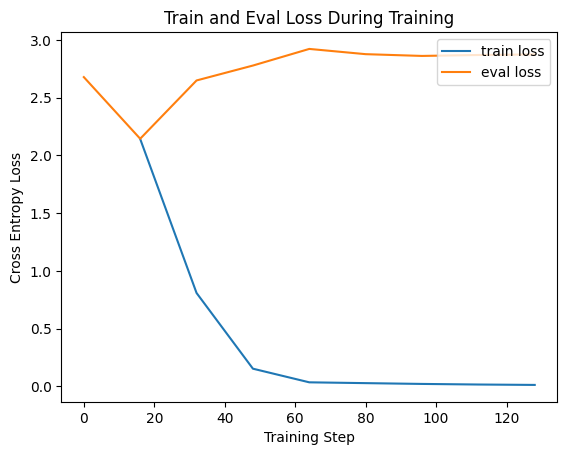

In [14]:
training_loss_history = []
eval_loss_history = [initial_eval_loss]
for step in trainer.state.log_history:
  if 'loss' in step:
    training_loss_history.append(step['loss'])
  elif "eval_loss" in step:
    eval_loss_history.append(step['eval_loss'])

print(training_loss_history)
print(eval_loss_history)

import matplotlib.pyplot as plt
time_steps = [i*16 for i in range(1, len(training_loss_history)+1)]
plt.plot(time_steps, training_loss_history, label="train loss")
plt.plot([0]+time_steps, eval_loss_history, label="eval loss")
plt.title("Train and Eval Loss During Training")
plt.xlabel("Training Step")
plt.ylabel("Cross Entropy Loss")
plt.legend(loc="upper right")
plt.show()

In [15]:
# saving the final model weights
final_model_path = "model/final_model"
trainer.save_model(final_model_path)

Saving model checkpoint to model/final_model
loading configuration file config.json from cache at /home/yuyuan/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/392a143b624368100f77a3eafaa4a2468ba50a72/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "ti

In [16]:
# move the model to the cpu and then delete the model, tokenizer and trainer objects
model.cpu()
del model, tokenizer, trainer
# We'll also call python to garbage collect any resources that might
# still be hanging around, and we'll clear the cuda cache.
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
import torch
final_model_path = "./model/final_model"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

# first we'll load in the base model
# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config=bnb_config,
    device_map="cuda")

# next we'll add our trained adapter to the model
model.load_adapter(final_model_path, adapter_name="adapter")

# now using enable_adapters and disable_adapters we can choose
# if we want to run inference on the model itself or have it be
# influenced by our newly trained weights
model.enable_adapters()

# also make sure we set the pad token, and for good measure turn off caching
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

# last we wrap the model in a hugging face pipeline for text-generation
# this helps streamline our inference code a bit by managing the inputs/outputs for us
model_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

loading file tokenizer.json from cache at /home/yuyuan/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/392a143b624368100f77a3eafaa4a2468ba50a72/tokenizer.json
loading file tokenizer.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/yuyuan/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/392a143b624368100f77a3eafaa4a2468ba50a72/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/yuyuan/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/392a143b624368100f77a3eafaa4a2468ba50a72/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.json from cache at /home/yuyuan/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/392a143b624368100f77a3eafaa4a2468ba50a72/config.json


In [18]:
# Helper function to get predictions for a list of samples using a model pipeline
def get_bulk_predictions(pipe, samples):
    # Generate responses using the pipeline
    responses = pipe(samples, max_new_tokens=512, batch_size=len(samples), do_sample=False)
    # Extract the generated text from the responses
    responses = [i[0]['generated_text'] for i in responses]
    return responses

# Function to get both base and fine-tuned model predictions for comparison
def get_base_and_tuned_bulk_predictions(samples):
    # Extract the conversation messages for each sample (ignoring the answer part)
    bulk_messages = [i[:-1] for i in samples['messages']]

    # Enable the fine-tuned model's adapters
    model.enable_adapters()
    # Get the predictions from the fine-tuned model
    trained_responses = get_bulk_predictions(model_pipe, bulk_messages)

    # Disable the adapters to use the base model
    model.disable_adapters()
    # Get the predictions from the base model
    base_responses = get_bulk_predictions(model_pipe, bulk_messages)

    # Return both base model predictions and fine-tuned model predictions
    return {"base_prediction": base_responses, "trained_prediction": trained_responses}


conversation_validation_samples = conversation_test_samples.map(get_base_and_tuned_bulk_predictions, batched=True, batch_size=1)

# for i in range(1):
#     print(f"Sample {i + 1}:")
#     print("Ground Truth Answer:")
#     print(conversation_validation_samples['answer'][i])  # The actual correct answer
#     print("Base Model Prediction:")
#     print(conversation_validation_samples['base_prediction'][i])  # Prediction from base model
#     print("Fine-Tuned Model Prediction:")
#     print(conversation_validation_samples['trained_prediction'][i])  # Prediction from fine-tuned model
#     print("-" * 40)  # Print separator between samples


Map:   0%|          | 0/1 [00:00<?, ? examples/s]Disabling tokenizer parallelism, we're using DataLoader multithreading already
/home/yuyuan/miniconda3/envs/readpdf/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/yuyuan/miniconda3/envs/readpdf/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Map: 100%|██████████| 1/1 [02:27<00:00, 147.19s/ examples]


In [19]:
# show the structure of the conversation_validation_samples
print(txt_texts[3])
print("---->")
#print the structure of conversation_validation_samples[0]['base_prediction']
for message in conversation_validation_samples[0]['base_prediction']:
    if message['role'] == 'assistant':
        print(message['content'])
print("---->")
for message in conversation_validation_samples[0]['trained_prediction']:
    if message['role'] == 'assistant':
        print(message['content'])

Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Ka

In [20]:
conversation_train_samples_ret = conversation_training_samples.map(get_base_and_tuned_bulk_predictions, batched=True, batch_size=1)


Map: 100%|██████████| 3/3 [09:54<00:00, 198.33s/ examples]


In [21]:
# show the structure of the conversation_validation_samples
id = 2
print(txt_texts[id])
print("---->")
#print the structure of conversation_validation_samples[0]['base_prediction']
for message in conversation_train_samples_ret[id]['base_prediction']:
    if message['role'] == 'assistant':
        print(message['content'])

print("---->")
for message in conversation_train_samples_ret[id]['trained_prediction']:
    if message['role'] == 'assistant':
        print(message['content'])

Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment
Carbon persistence of soils with long-term biosolids amendments in California agroecosystems,"Yocelyn B. Villa, Eddie Phosalath, Rebecca Ryals",Sacramento County,121°10′06.5″W,38°20′06.3″N,,,,,,,,2023,20 years,Alfisols,"Hicksville, Corning",,,This site consisted of flo

# Results
## training set
### paper 1
**Ground Truth:**
``` script
Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment
Agricultural peatland restoration: effects of land-use change on greenhouse gas (CO2 and CH4) fluxes in the Sacramento-San Joaquin Delta,"Sara Helen Knox, Cove Sturtevant, Jaclyn Hatala Matthes, Laurie Koteen, Joseph Verfaillie, Dennis Baldocchi",Sacramento-San Joaquin Delta,,,,335,,16.4,,,,,,,,,,Conventional drained agricultural sites Pasture,Conventional drained agricultural sites corn,,,,,,,5.84 to 11.4,,,,341,278,293,
``` 
**original model output:**
```` script
"Paper_Title","Authors","Site_Location","Longitude","Latitude","Elevation_m","Mean_precipitation","Min_Temp","Mean_temp","Max_temp","Date_Measurements","Month_of_Measurement","Year_of_Measurement","Duration_of_Treatment_starting_year","SoilOrder","SoilSeries","Soil_Texture_topsoil_less_than_20_cm","SoilBulkDensity_g_cm3","LandUse","LandManagement_Treatment","CarbonInput_Mg_per_ha_per_year","Topsoil_Soil_Organic_Carbon_Control_g_per_kg","Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg","Topsoil_carbon_stock_change_Mg_per_ha","N2O_flux_control","N2O_flux_treatment","CH4_flux_control_g_C_per_m2","CH4_flux_treatment_g_C_per_m2","CO2_flux_control","CO2_flux_treatment","NEE_flux_control_g_C_per_m2","NEE_flux_treatment_g_C_per_m2","CropYield_biomass_harvest_control","CropYield_biomass_treatment"
"Agriultural peatland restoration: effects of land-use change on greenhouse gas (CO2 and CH4) fluxes in the Sacramento-San Joaquin Delta","S A R A H E L E N K N O X [1], C O V E S T U R T E V A N T [1], J A C L Y N H A T A L A M A T T H E S [2], L A U R I E K O T E E N [3], J O S E P H V E R F A I L L I E [1] and DENNIS BALDOCCHI [1]","Sacramento-San Joaquin Delta, California, USA","-121.7540° W","38.0366° N","0","263 mm","10 °C","22 °C","30 °C","1 March 2012–1 9 May 2012","May","2012","1997","Clay Loam","Saratan","Loamy","Yes","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No","No
````
**fine-tuned model output:**
```` script
Here is the output in the requested format:

**Paper_Title:** Agricultural peatland restoration: effects of land-use change on greenhouse gas (CO2 and CH4) fluxes in the Sacramento-San Joaquin Delta

**Authors:** Sarah E. Helen Knox, C. Sturtevant, L. Koteen, P. Oikawa, J. Verfaillie, D. Baldocchi

**Site_Location:** Sacramento-San Joaquin Delta, California, USA

**Longitude:** 121.7540° W

**Latitude:** 38.0366° N

**Elevation_m:** 7 m

**Mean_precipitation:** 263 mm

**Min_Temp:** 14.9 °C

**Mean_temp:** 16.4 °C

**Max_temp:** 22.2 °C

**Date_Measurements:** 1 March 2012–1 9 May 2012–9 1 March 2012–1 1 August 2012–1 1 March 2012–1 1 August 2012

**Month_of_Measurement:** March, May, March, August

**Year_of_Measurement:** 2012, 2012, 2012, 2012, 2012

**Duration_of_Treatment_starting_year:** 2007, 2009, 2010, 2010, 2010

**SoilOrder:** Peat

**SoilSeries:** Sherman Island

**Soil_Texture_topsoil_less_than_20_cm:** Peat

**SoilBulkDensity_g_cm3:** 0.65

**LandUse:** Conventional drained agriculture

**LandManagement_Treatment:** Conventional drained agriculture

**CarbonInput_Mg_per_ha_per_year:** 0

**Topsoil_Soil_Organic_Carbon_Control_g_per_kg:** 0

**Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg:** 0

**Topsoil_carbon_stock_change_Mg_per_ha:** 0

**N2O_flux_control:** N/A

**N2O_flux_treatment:** N/A

**CH4_flux_control_g_C_per_m2:** 11.4 g C m[�][2]

**CH4_flux_treatment_g_C_per_m2:** 53 g C m[�][2]

**CO2_flux_control
````
### paper 2
**Ground Truth:**
``` script
Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment
Synergy between compost and cover crops in a Mediterranean row crop system leads to increased subsoil carbon storage,"Daniel Rath, Nathaniel Bogie, Leonardo Deiss, Sanjai J. Parikh, Daoyuan Wang, Samantha Ying, Nicole Tautges, Asmeret Asefaw Berhe, Teamrat A. Ghezzehei, and Kate M. Scow",Davis,,,16,,,,,,,2018,1993,,"Yolo, Rincon","silt loam, silty clay loam",,"All plots are in a 2-year maize–tomato rotation, with three replicate plots of each crop in any given year. Each treatment sampled in this paper consisted of three plots under tomato and three plots under corn to give a total of nine corn plots and nine tomato plots in total. All plots were irrigated with subsurface drip at the time of sampling, having converted from furrow irrigation to subsurface drip in 2014. All plots also received four tillage passes to a depth of 20.5 cm, and ORG and CONV+WCC plots received additional tillage passes to 6.5 cm to incorporate cover crop and compost residue (Table A5).",CONV (mineral fertilizer),110,,,-3,,,,,,,,,,
Synergy between compost and cover crops in a Mediterranean row crop system leads to increased subsoil carbon storage,"Daniel Rath, Nathaniel Bogie, Leonardo Deiss, Sanjai J. Parikh, Daoyuan Wang, Samantha Ying, Nicole Tautges, Asmeret Asefaw Berhe, Teamrat A. Ghezzehei, and Kate M. Scow",Davis,,,16,,,,,,,2018,1993,,"Yolo, Rincon","silt loam, silty clay loam",,"All plots are in a 2-year maize–tomato rotation, with three replicate plots of each crop in any given year. Each treatment sampled in this paper consisted of three plots under tomato and three plots under corn to give a total of nine corn plots and nine tomato plots in total. All plots were irrigated with subsurface drip at the time of sampling, having converted from furrow irrigation to subsurface drip in 2014. All plots also received four tillage passes to a depth of 20.5 cm, and ORG and CONV+WCC plots received additional tillage passes to 6.5 cm to incorporate cover crop and compost residue (Table A5).",CONV+WCC (mineral fertilizer and cover-cropped),120,,,0,,,,,,,,,,
Synergy between compost and cover crops in a Mediterranean row crop system leads to increased subsoil carbon storage,"Daniel Rath, Nathaniel Bogie, Leonardo Deiss, Sanjai J. Parikh, Daoyuan Wang, Samantha Ying, Nicole Tautges, Asmeret Asefaw Berhe, Teamrat A. Ghezzehei, and Kate M. Scow",Davis,,,16,,,,,,,2018,1993,,"Yolo, Rincon","silt loam, silty clay loam",,"All plots are in a 2-year maize–tomato rotation, with three replicate plots of each crop in any given year. Each treatment sampled in this paper consisted of three plots under tomato and three plots under corn to give a total of nine corn plots and nine tomato plots in total. All plots were irrigated with subsurface drip at the time of sampling, having converted from furrow irrigation to subsurface drip in 2014. All plots also received four tillage passes to a depth of 20.5 cm, and ORG and CONV+WCC plots received additional tillage passes to 6.5 cm to incorporate cover crop and compost residue (Table A5).",ORG (composted poultry manure and cover-cropped),180,,,5,,,,,,,,,,
``` 
**original model output:**
```` script
Based on the provided context, I will generate a passage that answers the user's question. Here is the output:

**Paper_Title:** Synergy between compost and cover crops in a Mediterranean row crop system leads to increased subsoil carbon storage
**Authors:** Daniel Rath, Nathaniel Bogie, Leonardo Deiss, Sanjai J. Parikh, Daoyuan Wang, Samantha Ying, Nicole Tautges, Asmeret Asefaw Berhe, Teamrat A. Ghezzehei, and Kate M. Scow
**Site_Location:** California Central Valley, USA
**Longitude:** -121.5° W
**Latitude:** 38.5° N
**Elevation_m:** 16 m
**Mean_precipitation:** 812 mm
**Min_Temp:** 16°C
**Mean_temp:** 29°C
**Max_temp:** 30°C
**Date_Measurements:** 2018-2019
**Month_of_Measurement:** February, June, September/October, February
**Year_of_Measurement:** 2018-2019
**Duration_of_Treatment_starting_year:** 25 years
**SoilOrder:** Mollic Xerofluvent
**SoilSeries:** Yolo silt loam
**Soil_Texture_topsoil_less_than_20_cm:** Fine-silty, mixed, superactive, non-acid
**SoilBulkDensity_g_cm3:** 1.3 g/cm³
**LandUse:** Row crop system
**LandManagement_Treatment:** CONV (mineral fertilizer), CONV + WCC (mineral fertilizer and cover-cropped), ORG (composted poultry manure and cover-cropped)
**CarbonInput_Mg_per_ha_per_year:** 186, 123, 113
**Topsoil_Soil_Organic_Carbon_Control_g_per_kg:** 0.24 g/kg
**Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg:** 0.24 g/kg
**Topsoil_carbon_stock_change_Mg_per_ha:** -3, 5, 19
**N2O_flux_control:** Not applicable
**N2O_flux_treatment:** Not applicable
**CH4_flux_control_g_C_per_m2:** Not applicable
**CH4_flux_treatment_g_C_per_m2:** Not applicable
**CO2_flux_control:** Not applicable
````
**fine-tuned model output:**
```` script
Here is the extracted data in a tabular format:

| Paper_Title | Authors | Site_Location | Longitude | Latitude | Elevation_m | Mean_precipitation | Min_Temp | Mean_temp | Max_temp | Date_Measurements | Month_of_Measurement | Year_of_Measurement | Duration_of_Treatment_starting_year | SoilOrder | SoilSeries | Soil_Texture_topsoil_less_than_20_cm | SoilBulkDensity_g_cm3 | LandUse | LandManagement_Treatment | CarbonInput_Mg_per_ha_per_year | Topsoil_Soil_Organic_Carbon_Control_g_per_kg | Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg | Topsoil_carbon_stock_change_Mg_per_ha | N2O_flux_control | N2O_flux_treatment | CH4_flux_control_g_C_per_m2 | CH4_flux_treatment_g_C_per_m2 | CO2_flux_control | CO2_flux_treatment | NEE_flux_control_g_C_per_m2 | NEE_flux_treatment_g_C_per_m2 | CropYield_biomass_harvest_control | CropYield_biomass_treatment |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
````

### paper 3
**Ground Truth:**
``` script
Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment
Carbon persistence of soils with long-term biosolids amendments in California agroecosystems,"Yocelyn B. Villa, Eddie Phosalath, Rebecca Ryals",Sacramento County,121°10′06.5″W,38°20′06.3″N,,,,,,,,2023,20 years,Alfisols,"Hicksville, Corning",,,This site consisted of flood-irrigated annual grasslands managed for grazing beef cattle. Livestock was rotated every 60–70 days depending on feed availability.,Biosolids were applied for 20 years as described in detail in Villa and Ryals (2021).,,2.03,1.47,,,,,,,,,,,
Carbon persistence of soils with long-term biosolids amendments in California agroecosystems,"Yocelyn B. Villa, Eddie Phosalath, Rebecca Ryals",Solano County,121°45′38.0″W,38°11′52.3″N,,,,,,,,,,"Alfisols, Vertisols","Antioch, Pescadero, Altamont",,,The Solano site consists of rainfed annual grasslands used for grazing lambs and beef cattle. Livestock are rotated seasonally and based on feed availability.,Biosolids were applied for 20 years as described in detail in Villa and Ryals (2021).,,0.85,1.73,,,,,,,,,,,
Carbon persistence of soils with long-term biosolids amendments in California agroecosystems,"Yocelyn B. Villa, Eddie Phosalath, Rebecca Ryals",Merced County,120°31′43.0″W,37°04′20.3″N,,,,,,,,,,"Mollisols, Alfisols","Pozo, Fresno",,,The site is flood irrigated and managed for livestock feed crops consisting of 1-year corn and 4-year alfalfa rotations for livestock silage and was tilled after each rotation.,Biosolids were applied for 20 years as described in detail in Villa and Ryals (2021).,,0.82,0.86,,,,,,,,,,,
``` 
**original model output:**
```` script
Based on the provided context passage, I will generate a passage that answers the user's question. Here is the generated passage:

**Paper_Title:** Carbon persistence of soils with long-term biosolids amendments in California agroecosystems

**Authors:** Yocelyn B. Villa, Eddie Phosalath, Rebecca Ryals

**Site_Location:** Sacramento, Solano, Merced, California, USA

**Longitude:** 121.10° W, 121.45° W, 120.31° W

**Latitude:** 38.20° N, 38.11° N, 37.04° N

**Elevation_m:** 10 m, 10 m, 10 m

**Mean_precipitation:** 400 mm, 400 mm, 400 mm

**Min_Temp:** 5°C, 5°C, 5°C

**Mean_temp:** 15°C, 15°C, 15°C

**Max_temp:** 30°C, 30°C, 30°C

**Date_Measurements:** 2015-2020

**Month_of_Measurement:** January, February, March

**Year_of_Measurement:** 2015-2020

**Duration_of_Treatment_starting_year:** 20 years

**SoilOrder:** Alfisols, Alfisols, Mollisols

**SoilSeries:** Hicksville, Corning, Pozo

**Soil_Texture_topsoil_less_than_20_cm:** Sandy loam, Sandy loam, Sandy loam

**SoilBulkDensity_g_cm3:** 1.2 g/cm³, 1.2 g/cm³, 1.2 g/cm³

**LandUse:** Irrigated annual grassland, Rainfed annual grassland, Feed cropping system with alfalfa-corn rotation

**LandManagement_Treatment:** Biosolids application, No biosolids application, Biosolids application

**CarbonInput_Mg_per_ha_per_year:** 100 Mg/ha, 100 Mg/ha, 100 Mg/ha

**Topsoil_Soil_Organic_Carbon_Control_g_per_kg:** 0.5 g/kg, 0.5 g/kg, 0.5 g/kg

**Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg:** 1.5 g/kg, 1.5 g/kg, 1.5 g/kg
````
**fine-tuned model output:**
```` script
| **Paper_Title** | **Authors** | **Site_Location** | **Longitude** | **Latitude** | **Elevation_m** | **Mean_precipitation** | **Min_Temp** | **Mean_temp** | **Max_temp** | **Date_Measurements** | **Month_of_Measurement** | **Year_of_Measurement** | **Duration_of_Treatment_starting_year** | **SoilOrder** | **SoilSeries** | **Soil_Texture_topsoil_less_than_20_cm** | **SoilBulkDensity_g_cm3** | **LandUse** | **LandManagement_Treatment** | **CarbonInput_Mg_per_ha_per_year** | **Topsoil_Soil_Organic_Carbon_Control_g_per_kg** | **Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg** | **Topsoil_carbon_stock_change_Mg_per_ha** | **N2O_flux_control** | **N2O_flux_treatment** | **CH4_flux_control_g_C_per_m2** | **CH4_flux_treatment_g_C_per_m2** | **CO2_flux_control** | **CO2_flux_treatment** | **NEE_flux_control_g_C_per_m2** | **NEE_flux_treatment_g_C_per_m2** | **CropYield_biomass_harvest_control** | **CropYield_biomass_treatment** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Carbon persistence of soils with long-term biosolids amendments in California agroecosystems | Villa, Y. B., Phosalath, E., Ryals, R., Duncan, R. A., Brown, P. H., & Hart, S. C. | Merced, CA, USA | 120.31° W | 37.04° N | 50 | 450 | 4 | 10 | 22 | 2013 | 20 | Alfisol | Fresno | Sandy
````

## test set
### paper 1
**Ground Truth:**
``` script
Paper_Title,Authors,Site_Location,Longitude,Latitude,Elevation_m,Mean_precipitation,Min_Temp,Mean_temp,Max_temp,Date_Measurements,Month_of_Measurement,Year_of_Measurement,Duration_of_Treatment_starting_year,SoilOrder,SoilSeries,Soil_Texture_topsoil_less_than_20_cm,SoilBulkDensity_g_cm3,LandUse,LandManagement_Treatment,CarbonInput_Mg_per_ha_per_year,Topsoil_Soil_Organic_Carbon_Control_g_per_kg,Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg,Topsoil_carbon_stock_change_Mg_per_ha,N2O_flux_control,N2O_flux_treatment,CH4_flux_control_g_C_per_m2,CH4_flux_treatment_g_C_per_m2,CO2_flux_control,CO2_flux_treatment,NEE_flux_control_g_C_per_m2,NEE_flux_treatment_g_C_per_m2,CropYield_biomass_harvest_control,CropYield_biomass_treatment
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2014,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.",1) mineral fertilizer without biochar;,"The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,10,,,,,,,,,,,
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2014,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.",2) mineral fertilizer with biochar;,"The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,10.5,,,,,,,,,,,
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2014,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.",3) compost without biochar;,"The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,10.2,,,,,,,,,,,
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2014,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.","4) compost with biochar, arranged in a randomized complete block design with four replicate blocks per treatment and one treatment replicate per block, making a total of 16 plots","The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,11,,,,,,,,,,,
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2018,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.",1) mineral fertilizer without biochar;,"The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,10.2,,,,,,,,,,,
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2018,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.",2) mineral fertilizer with biochar;,"The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,10.5,,,,,,,,,,,
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2018,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.",3) compost without biochar;,"The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,12.2,,,,,,,,,,,
Compost amendment maintains soil structure and carbon storage by increasing available carbon and microbial biomass in agricultural soil – A six-year field study,"Daoyuan Wang, Jonathan Y. Lin, ,Jordan M. Sayre, Radomir Schmidt, Steven J. Fonte, Jorge L.M. Rodrigues, Kate M. Scow",Davis,121°52′28″W,38°32′47″N,,,,,,,,2018,2012,,Rincon,silty clay loam,1.3,"The field was kept fallow for 10 years before 2012, except for a season of Montezuma oats grown between October 2009 and March 2010. The cropping system consisted of a 2-yr rotation of processing tomatoes (Lycopersicon esculentum Mill.) and corn (Zea mays L.). The farm management was based on practices and equipment similar to that used by local commercial growers.","4) compost with biochar, arranged in a randomized complete block design with four replicate blocks per treatment and one treatment replicate per block, making a total of 16 plots","The average annual above-ground C input in the mineral fertilizer treatment without biochar was 4.30 Mg C ha−1 year−1 as crop residue. Based on calculations for the adjacent Century Experiment at Russell Ranch that includes crop rotations with identical compost and cover crop management, the compost without biochar treatment received an average annual input of 7.27 Mg C ha−1 year−1 for the first 4 years and 6.52 Mg C ha−1 year−1 for the remaining duration of the experiment, of which approximately 2.22 Mg C ha−1 year−1 was accounted for by the compost amendment (Tautges et al., 2019). The biochar-amended treatments both received 5.53 Mg C ha−1 as biochar-C (only in Year 1) in addition to the carbon inputs above.",,12.5,,,,,,,,,,,
``` 
**original model output:**
```` script
Based on the provided context passage, I will generate a passage that answers the user's question. Here is the generated passage:

**Paper_Title:** Carbon persistence of soils with long-term biosolids amendments in California agroecosystems

**Authors:** Yocelyn B. Villa, Eddie Phosalath, Rebecca Ryals

**Site_Location:** Sacramento, Solano, Merced, California, USA

**Longitude:** 121.10° W, 121.45° W, 120.31° W

**Latitude:** 38.20° N, 38.11° N, 37.04° N

**Elevation_m:** 10 m, 10 m, 10 m

**Mean_precipitation:** 400 mm, 400 mm, 400 mm

**Min_Temp:** 5°C, 5°C, 5°C

**Mean_temp:** 15°C, 15°C, 15°C

**Max_temp:** 30°C, 30°C, 30°C

**Date_Measurements:** 2015-2020

**Month_of_Measurement:** January, February, March

**Year_of_Measurement:** 2015-2020

**Duration_of_Treatment_starting_year:** 20 years

**SoilOrder:** Alfisols, Alfisols, Mollisols

**SoilSeries:** Hicksville, Corning, Pozo

**Soil_Texture_topsoil_less_than_20_cm:** Sandy loam, Sandy loam, Sandy loam

**SoilBulkDensity_g_cm3:** 1.2 g/cm³, 1.2 g/cm³, 1.2 g/cm³

**LandUse:** Irrigated annual grassland, Rainfed annual grassland, Feed cropping system with alfalfa-corn rotation

**LandManagement_Treatment:** Biosolids application, No biosolids application, Biosolids application

**CarbonInput_Mg_per_ha_per_year:** 100 Mg/ha, 100 Mg/ha, 100 Mg/ha

**Topsoil_Soil_Organic_Carbon_Control_g_per_kg:** 0.5 g/kg, 0.5 g/kg, 0.5 g/kg

**Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg:** 1.5 g/kg, 1.5 g/kg, 1.5 g/kg
````
**fine-tuned model output:**
```` script
Here is the extracted data in a tabular format:

| **Paper_Title** | **Authors** | **Site_Location** | **Longitude** | **Latitude** | **Elevation_m** | **Mean_precipitation** | **Min_Temp** | **Mean_temp** | **Max_temp** | **Date_Measurements** | **Month_of_Measurement** | **Year_of_Measurement** | **Duration_of_Treatment_starting_year** | **SoilOrder** | **SoilSeries** | **Soil_Texture_topsoil_less_than_20_cm** | **SoilBulkDensity_g_cm3** | **LandUse** | **LandManagement_Treatment** | **CarbonInput_Mg_per_ha_per_year** | **Topsoil_Soil_Organic_Carbon_Control_g_per_kg** | **Topsoil_Soil_Organic_Carbon_Treatment_g_per_kg** | **Topsoil_carbon_stock_change_Mg_per_ha** | **N2O_flux_control** | **N2O_flux_treatment** | **CH4_flux_control_g_C_per_m2** | **CH4_flux_treatment_g_C_per_m2** | **CO2_flux_control** | **CO2_flux_treatment** | **NEE_flux_control_g_C_per_m2** | **NEE_flux_treatment_g_C_per_m2** | **CropYield_biomass_harvest_control** | **CropYield_biomass_treatment** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Carbon persistence of soils with long-term biosolids amendments in California agroecosystems | Villa, Y. B., Phosalath, E., Ryals, R., Duncan, R. A., Brown, P. H., & Hart, S. C. | Merced, CA, USA | 120.31° W | 37.04° N | 50 | 450 | 4 | 10 | 22 | 2013 | 20 | Alfisol | Fresno | Sandy
````